In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import xarray as xr

In [10]:
### Read data
f_in = Path('/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/osse/processed_amrwind_obs/attempt_june24/y11520/long-upsampled-inflow-3D.nc')
ds_in = xr.open_dataset(f_in)

# f_out_single = Path(f_in.parent, 'for_palette2D_sampling.pt')
dir_out_batch = Path(f_in.parent, 'for_palette2D_sampling')
dir_out_batch.mkdir(exist_ok=True)

In [11]:
ds_in

<xarray.Dataset> Size: 150kB
Dimensions:  (y: 21, time: 849)
Coordinates:
  * y        (y) float64 168B -100.0 -90.0 -80.0 -70.0 ... 70.0 80.0 90.0 100.0
  * time     (time) datetime64[ns] 7kB 1970-01-01T03:30:16 ... 1970-01-01T03:...
Data variables:
    U        (y, time) float64 143kB ...

In [12]:
### Trim and reformat
## Input data shape parameters
ntime_out = 704
ny_out = 32
nchan_out = 5
jlo_upsampled = 6  # From advect_interpolate/les/31a_merge_upsampled_and_wide_gt.ipynb
jhi_upsampled = jlo_upsampled + 21

## Data for nan-filling
nan_replacement_vec = np.array([9.25163471,  # From advect_interpolate_les_32a_chunk_and_clean.ipynb
                                0.4404083,
                                1.07286723,
                                319.17731398,
                                0.4212696])

## Trim to numpy array
print(f"Number of timesteps in the input data file: {len(ds_in['time'])}")
print(f"Taking the last {ntime_out} timesteps")
print(f"Width of input data: {len(ds_in['y'])}")
print(f"Populating width indicies {jlo_upsampled} - {jhi_upsampled}")
      
arr_out = np.ones((nchan_out, ntime_out, ny_out)) * nan_replacement_vec[:,np.newaxis,np.newaxis]
arr_out[0,:,jlo_upsampled:jhi_upsampled] = ds_in['U'].values[:,-1*ntime_out:].T.copy()
for ivar in range(5):
    arr_out[ivar] = np.nan_to_num(arr_out[ivar], nan=nan_replacement_vec[ivar], copy=True)
np.save(Path(dir_out_batch, 'cts_timeseries.npy'), arr_out)
    
## Reformat into PyTorch
pt_data_out = torch.from_numpy(arr_out).float()
pt_out = {}
pt_out['x'] = pt_data_out.detach().clone()  # NOTE: THE .DETATCH().CLONE() IS NECESSARY IF THE SAME ARR IS USED IN X OR Y, OR A SNEAKY BUG APPEARS
pt_out['y'] = pt_data_out.detach().clone()  # The data loader needs 'y', but will ignore it

# torch.save(pt_out, f_out)

nbatch = 32
with open(Path(dir_out_batch, 'sample.flist'), 'w') as f:
    for ibatch in range(nbatch):
        curr_f_out = Path(dir_out_batch, f'{str(ibatch).zfill(2)}.pt')
        f.write(str(curr_f_out)+'\n')
        torch.save(pt_out, curr_f_out)

Number of timesteps in the input data file: 849
Taking the last 704 timesteps
Width of input data: 21
Populating width indicies 6 - 27


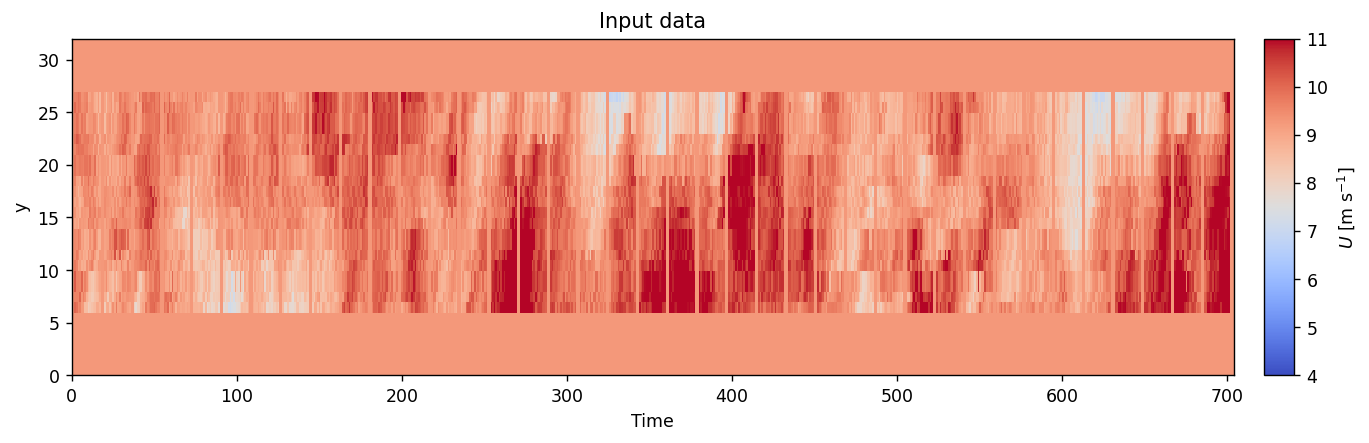

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5), dpi=125, sharex=True, sharey=True)

## Decorate
cmap = 'coolwarm'
ax.set_ylabel("y")
ax.set_xlabel("Time")

ax.set_title("Input data")

data0 = pt_out['x'][0,:,:]
vmin, vmax = 4, 11
# data0 = pt_out['x'][3,:,:]
# vmin, vmax = 317, 320

im0 = ax.pcolor(data0.T,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                shading="auto")

# im1 = ax[1].pcolor(data1.T,
#                 cmap=cmap,
#                 shading="auto")

## Colorbars
cax0 = fig.add_axes([ax.get_position().x1+0.02,
                     ax.get_position().y0,
                     0.02,
                     ax.get_position().y1-ax.get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$U$ [m s$^{-1}$]')
cbar0.ax.tick_params()

plt.show()